### Code for generation of stage-wise Subsets
_Single cell trajectory mapping of human pluripotent stem cells differentiating towards lung and hepatocyte progenitors_,
bioArxiv Preprint. <br> 
Chaido Ori, Meshal Ansari, Ilias Angelidis, Fabian J. Theis, Herbert B. Schiller and Micha Drukker

In [1]:
## This Notebook generates and saves subsets used in the Notebooks associated with Ori et al., 2021
## Definite Endoderm (DE) and Foregut Endoderm (FE) subsets are used in Figure 3 and 4

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
import IPython

from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

### Read in data object

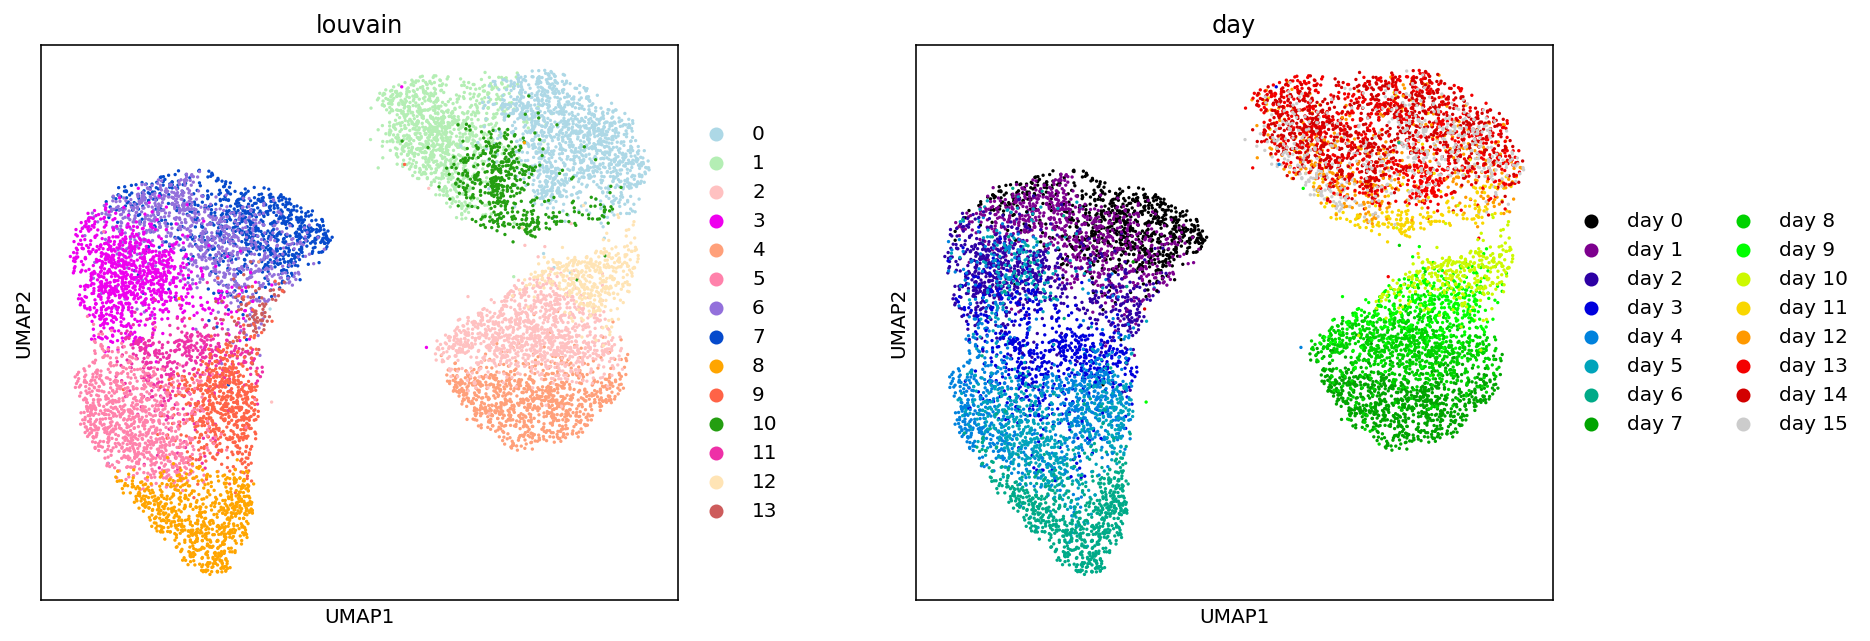

In [2]:
IPython.display.set_matplotlib_formats("png2x", quality = 90)
plt.rcParams["figure.figsize"] = (5.5, 5)

folder = "/20200806_Drukker_IPSlungProgenitors_meshal.ansari/"
adata = sc.read(folder + "IPS_lung_differentiation.h5ad")
sc.pl.umap(adata, color = ["louvain", "day"], wspace = 0.25)

### Definite Endoderm stage subset (day 0 to day 6)

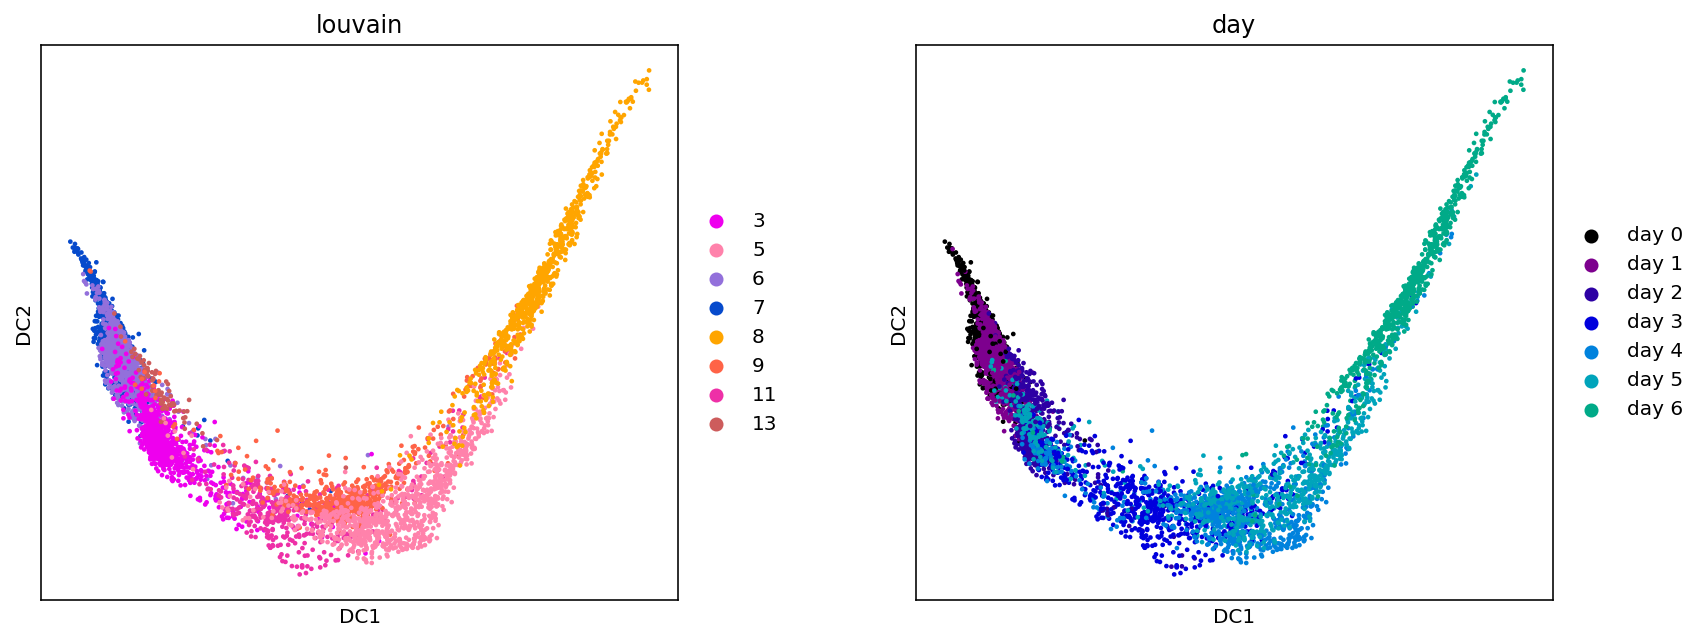

In [3]:
de = adata[adata.obs.day.isin(["day 0", "day 1", "day 2", "day 3", "day 4", "day 5", "day 6"]) &\
           adata.obs.louvain.isin(["7", "6", "3", "13", "11", "8", "9", "5"])].copy()

## Calculate PCs, neighborhood graph and umap with these parameters
# sc.pp.neighbors(de, n_pcs = 15, n_neighbors = 30)
# sc.tl.diffmap(de)
# sc.pl.diffmap(de, color = ["louvain", "day"])

## Set it based on coordinates to be consistend with figures
dm_cords = pd.read_csv(folder + "DE_FE_ELP_stagewise_diffmap_coords.txt", sep = "\t", index_col = 0)

de.obsm["X_diffmap"] = dm_cords.loc[de.obs_names, ["DE_DC_1", "DE_DC_1", "DE_DC_2"]].values
sc.pl.diffmap(de, color = ["louvain", "day"], wspace = 0.25)

In [4]:
## Save definite endoderm subset
de.write(folder + "IPS_lung_differentiation_defendo.h5ad")

### Foregut Endoderm stage subset (day 6 to day 10)

... storing 'stage' as categorical


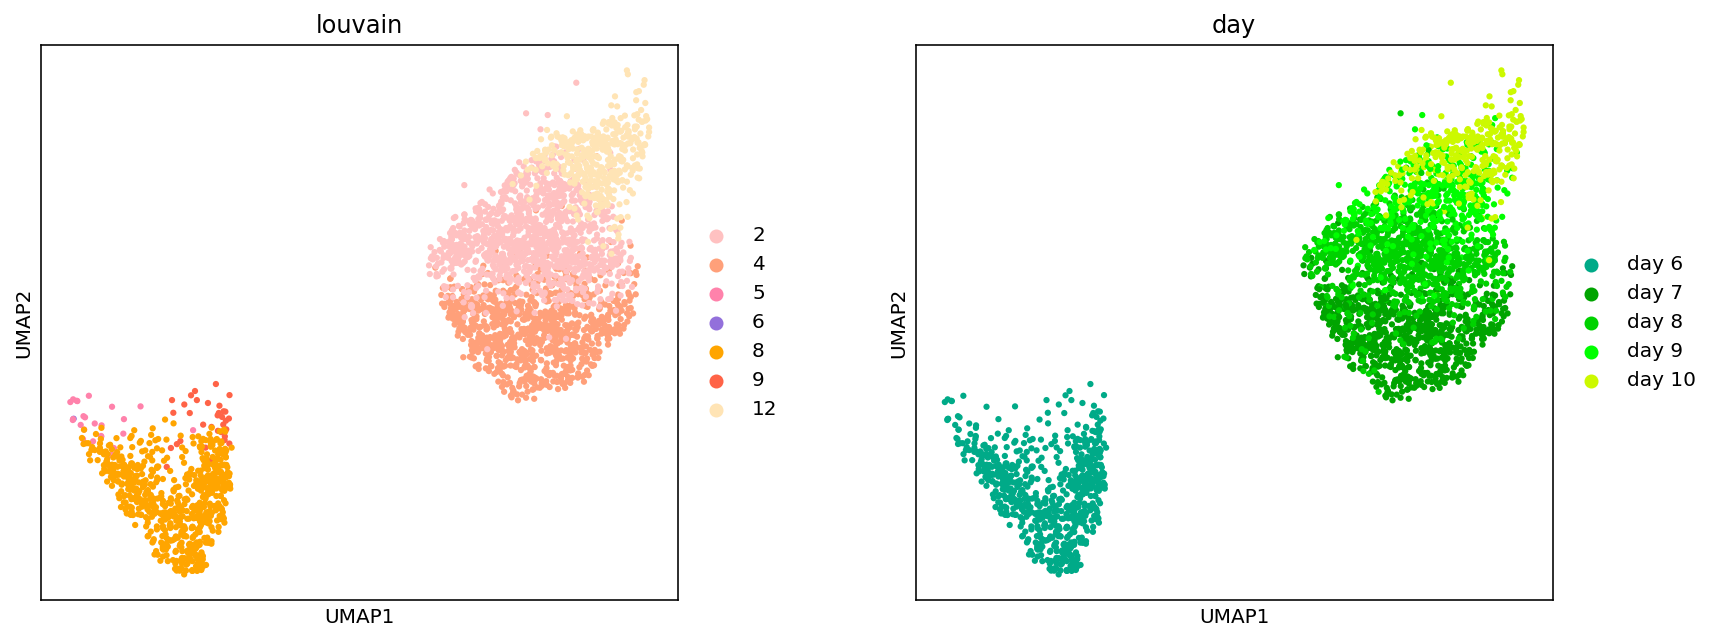

In [5]:
fe = adata[adata.obs.day.isin(["day 6", "day 7", "day 8", "day 9", "day 10"])].copy()

## Remove outlying cells based on UMAP
from sklearn.cluster import DBSCAN
from natsort import natsorted

fe.obs["d_cluster"] = DBSCAN(eps = 1, min_samples = 50).fit(fe.obsm["X_umap"]).labels_
c = fe.obs["d_cluster"].astype("U")
fe.obs["d_cluster"] = pd.Categorical(c, categories = natsorted(np.unique(c)))

fe = fe[fe.obs.d_cluster.isin(["0", "1"])].copy()
fe.obs["stage"] = ["FE" if d != "day 6" else "DE" for d in fe.obs.day]
sc.pl.umap(fe, color = ["louvain", "day"], wspace = 0.25)

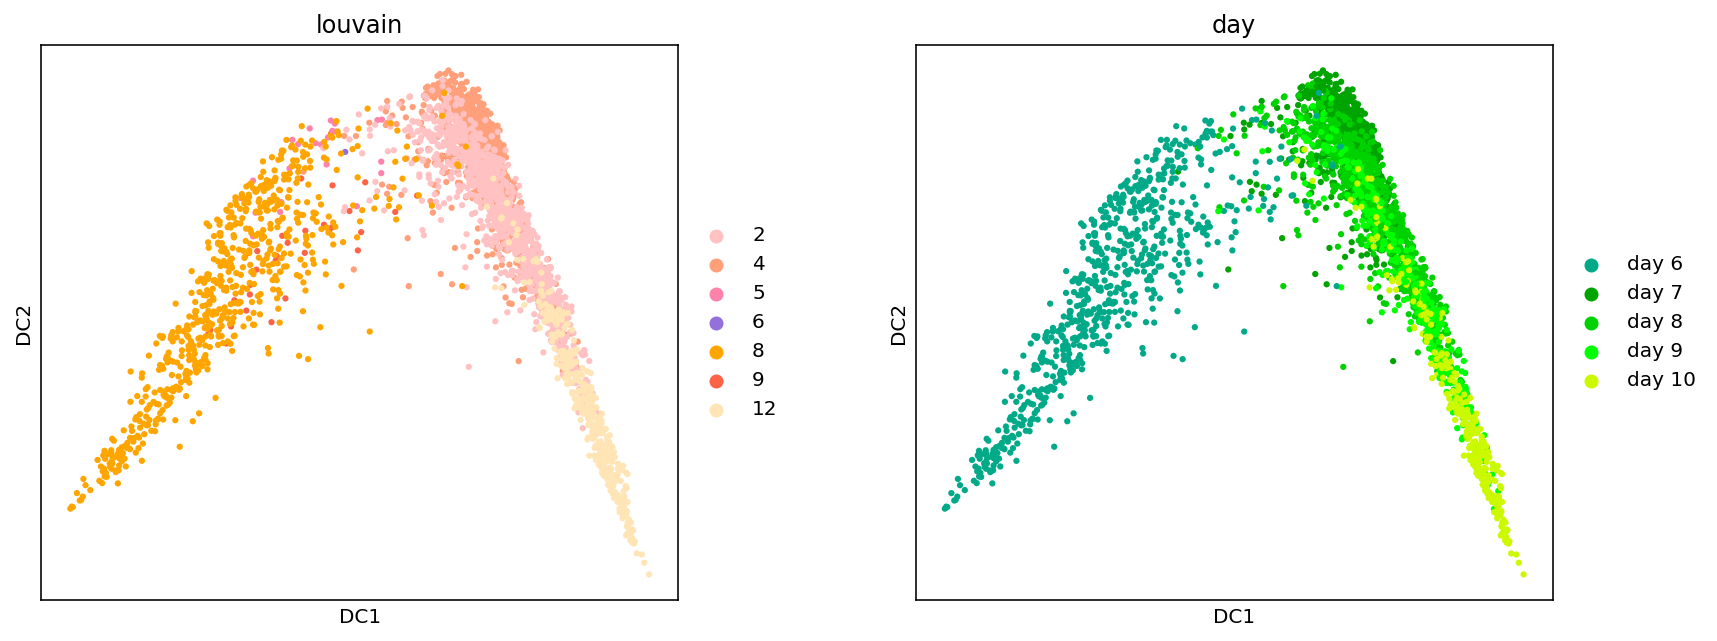

In [7]:
## Remove genes distinguishing DE stage and FE stage from list of highly variable genes
adata_raw = sc.AnnData(X = fe.raw.X)
adata_raw.obs = fe.obs
adata_raw.var = fe.raw.var.copy()

sc.pp.highly_variable_genes(adata_raw, batch_key = "stage", n_top_genes = 6000, n_bins = 20,
                            flavor = "cell_ranger", subset = False)
vartab = pd.DataFrame(adata_raw.var["highly_variable_nbatches"], index = adata_raw.var_names)

thresh = 2
hvgs = vartab[vartab.highly_variable_nbatches.values >= thresh].index
print("%s Genes kept, variable in at least %s samples" %(len(hvgs), thresh))
fe.var["highly_variable"] = [g in hvgs for g in fe.var_names]

## Calculate PCs, neighborhood graph and umap with these parameters
# sc.pp.pca(fe, n_comps = 50, use_highly_variable = True)
# sc.pp.neighbors(fe, n_pcs = 8, n_neighbors = 15)
# sc.tl.umap(fe)
# sc.tl.diffmap(fe)

## Set it based on coordinates to be consistend with figures
fe.obsm["X_diffmap"] = dm_cords.loc[fe.obs_names, ["FE_DC_1", "FE_DC_1", "FE_DC_2"]].values
sc.pl.diffmap(fe, color = ["louvain", "day"], wspace = 0.25)

In [8]:
## Save foregut endoderm + day 6 subset
fe.write(folder + "IPS_lung_differentiation_forendo.h5ad")

### Foregut Endoderm and Early Lung Progenitor stage

In [9]:
## Read differential gene expression Result Table based on Bulk data (GFP+ vs GFP-)
## Select those genes with logFC > 1 as lung genes and logFC < -1 as non lung genes

markers = pd.read_csv(folder + "GFPposVSneg_bulk.txt", sep = "\t", decimal = ",")
diff_genes = markers[abs(markers["log2FoldChange"]) > 1].symbol
diff_genes = [g for g in diff_genes.values if not str(g).startswith("RP") and not str(g).startswith("MT-")]

adata.obs["stage"] = ["ELP" if d in ["day 11", "day 12", "day 13", "day 14", "day 15" ]
                      else "FE" if d in ["day 7", "day 8", "day 9", "day 10"]  else "DE" for d in adata.obs["day"]]
sub = adata[adata.obs.stage.isin(["FE", "ELP"])].copy()
sub.uns["stage_colors"] = ["crimson", "deepskyblue"]

### Remove genes that distinguish the two stages

In [10]:
sc.tl.rank_genes_groups(sub, groupby = "stage", use_raw = True, method = "wilcoxon", n_genes = 100)

## Combine into one Data Frame
result = sub.uns['rank_genes_groups']
allMarkers = []
for cluster in result['names'].dtype.names:
    current = pd.DataFrame({"gene": result["names"][cluster], "score": result["scores"][cluster],
                            "logfoldchange": result["logfoldchanges"][cluster], "pval": result["pvals"][cluster],
                            "pval_adj": result["pvals_adj"][cluster], "cluster": cluster})
    allMarkers.append(current)
allMarkers = pd.concat(allMarkers)

batch_genes = allMarkers[abs(allMarkers["logfoldchange"]) > 1].gene.values
diff_genes = [g for g in diff_genes if not str(g) in batch_genes]

sub.var["highly_variable"] = [g in diff_genes for g in sub.var_names]
sum(sub.var["highly_variable"])

... storing 'stage' as categorical


1294

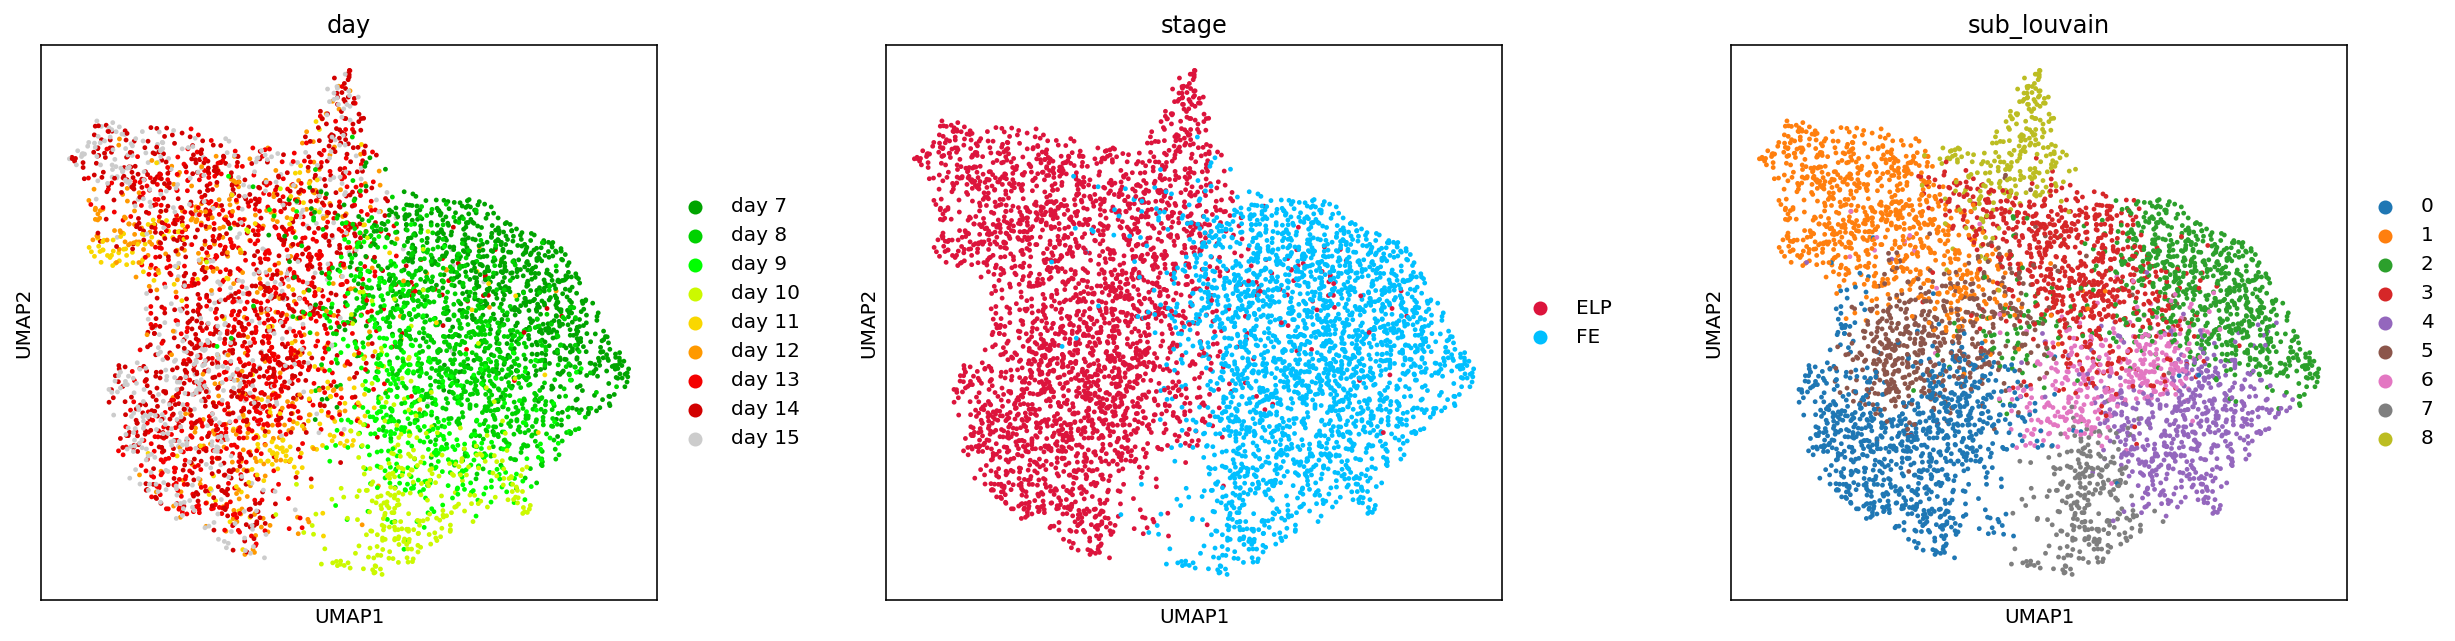

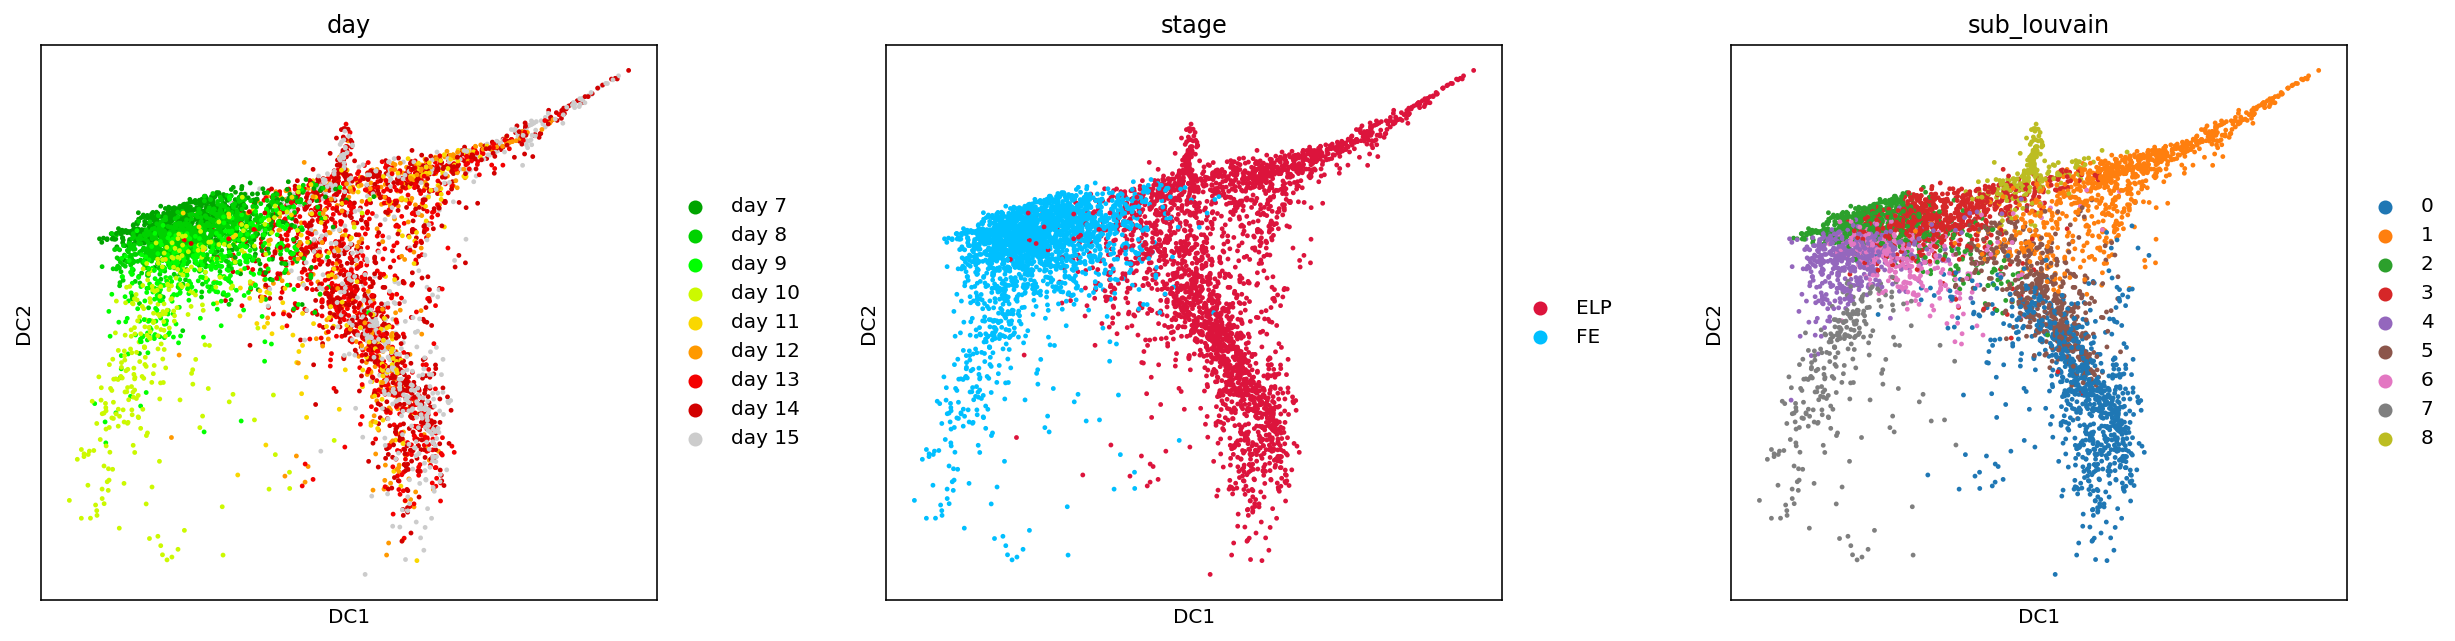

In [17]:
## Original Parameters for PCA, neighborhood graph and umap calculation
# sc.pp.pca(sub, n_comps = 50, use_highly_variable = True)
# sc.pp.neighbors(sub, n_pcs = 8, n_neighbors = 10)
# sc.tl.louvain(sub, resolution = .8, key_added = "sub_louvain")
# sc.tl.umap(sub)
# sc.tl.diffmap(sub)

## Set it based on coordinates to be consistend with figures
sub.obsm["X_diffmap"] = dm_cords.loc[sub.obs_names, ["FE_ELP_DC_1", "FE_ELP_DC_1",
                                                     "FE_ELP_DC_2", "FE_ELP_DC_3"]].values

sc.pl.umap(sub, color = ["day", "stage", "sub_louvain"], wspace = 0.25)
sc.pl.diffmap(sub, color = ["day", "stage", "sub_louvain"], wspace = 0.25)

In [18]:
## Save foregut endoderm + early lung progenitor subset
sub.write(folder + "IPS_lung_differentiation_forendo_elungpro.h5ad")